# Accessing and analysing web resources with pygplates

### Overview

This notebook goes through the steps of
- accessing geoscientific data directly from web servers and loading into python
- converting these data into a GPlates-compatible version
- carrying out spatial analysis that compares fossil occurences to the locations of interpreted paleoshorelines through geological time


### Part 1

The first part of this exercise goes through the actions of getting data sets directly from web services, and loading them into your python workspace. 

Let's start by doing something that has nothing to do with GPlates whatsoever. We use a python module called 'requests' to make a request to a web service run by the USGS, and load the data into a pandas dataframe (the function 'StringIO' is also used to help pandas recognise the data stream that comes back from the USGS web service as something resembling a csv file).

Note that when you run the next cell, you will have to wait for a while as the data is downloaded.

To quickly see what is in returned data, we can print the resulting text, which reveals a stream of data in csv format.


In [1]:
import requests
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

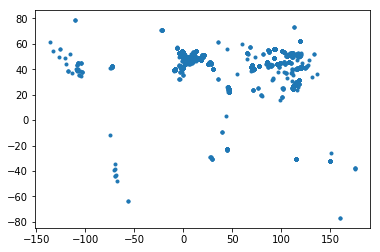

In [2]:
# SOLUTION
r = requests.get('https://paleobiodb.org/data1.1/occs/list.csv?limit=all&interval_id=15&base_id=18891&show=coords,attr,loc,prot,time,strat,stratext,lith,lithext,geo,rem,ent,entname,crmod&showsource')

#print r.text

df = pd.read_csv(StringIO(r.text),skiprows=15)

plt.plot(df.lng,df.lat,'.')


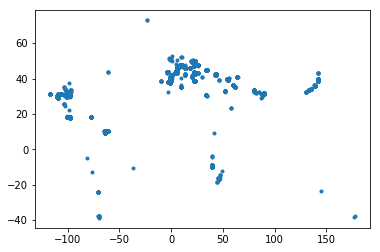

In [2]:
r = requests.get('https://paleobiodb.org/data1.1/occs/list.csv?limit=all&interval_id=40&base_id=4524&show=coords,attr,loc,prot,time,strat,stratext,lith,lithext,geo,rem,ent,entname,crmod&showsource')

df = pd.read_csv(StringIO(r.text),skiprows=15)

plt.plot(df.lng,df.lat,'.')


#### Creating a GPlates Feature Collection

To do something with these fossil data - either with GPlates or pygplates - we first need to convert the data into a 'feature collection'. The following example shows how to take the coordinates from each fossil occurence in the dataframe and make a GPlates 'Point feature'. We append each feature to a big list of features, then save this to a 'Feature Collection' that GPlates can read.

In [3]:
import pygplates

fossil_point_features = []
for index,row in df.iterrows():
    point = pygplates.PointOnSphere(float(row.lat),float(row.lng))
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    fossil_point_features.append(point_feature)
    
# Having created a list of features, we need to tell pygplates that this is a coherent 'Feature Collection'
# Then, we can save it to a file
# [note that the file format is controlled by the file extension we enter - can be *.gpml, *.gmt or *.shp]
output_feature_collection = pygplates.FeatureCollection(fossil_point_features)
output_feature_collection.write('my_fossils.gpml')


Load this feature collection into GPlates and look at it.

Questions:
- what information is missing from this feature collection that would be useful to assign to it?
- how can we assign that information (either in GPlates or within the python notebook)?  

HINTS: 
- one of the tutorials should help on this point
- the set_shapefile_attribute('')


### Part 2: Fossils and depositional environments

The rest of this notebook begins to consider the question 'what do fossils tell us about paleoenvironments?'

First, look at what types of attributes we have for each fossil, by listing the columns


In [4]:
df.columns

Index([u'occurrence_no', u'record_type', u'reid_no', u'superceded',
       u'collection_no', u'taxon_name', u'taxon_rank', u'taxon_no',
       u'matched_name', u'matched_rank', u'matched_no', u'early_interval',
       u'late_interval', u'early_age', u'late_age', u'reference_no', u'lng',
       u'lat', u'cc', u'state', u'county', u'geogscale', u'protected',
       u'early_age.1', u'late_age.1', u'cx_int_no', u'early_int_no',
       u'late_int_no', u'formation', u'stratgroup', u'member', u'stratscale',
       u'zone', u'localsection', u'localbed', u'localorder',
       u'regionalsection', u'regionalbed', u'regionalorder', u'stratcomments',
       u'lithdescript', u'lithology1', u'lithadj1', u'lithification1',
       u'minor_lithology1', u'fossilsfrom1', u'lithology2', u'lithadj2',
       u'lithification2', u'minor_lithology2', u'fossilsfrom2', u'environment',
       u'tectonic_setting', u'geology_comments', u'collection_aka',
       u'authorizer_no', u'enterer_no', u'modifier_no', u'auth

We are going to focus on the column called 'environment', which contains information about the sedimentary depositional environment of the rock that hosts the fossil (at least according to the interpretation of the geologist who found the fossil). Let's look at the values in that column (only the first part of the full dataframe is listed)

In [5]:
df.environment

0                           NaN
1                 marine indet.
2                           NaN
3                           NaN
4                           NaN
5                           NaN
6                           NaN
7                           NaN
8                 marine indet.
9                 marine indet.
10                marine indet.
11                marine indet.
12                marine indet.
13                marine indet.
14                marine indet.
15                marine indet.
16                marine indet.
17                marine indet.
18                marine indet.
19      shallow subtidal indet.
20      shallow subtidal indet.
21      shallow subtidal indet.
22      shallow subtidal indet.
23      shallow subtidal indet.
24      shallow subtidal indet.
25      shallow subtidal indet.
26      shallow subtidal indet.
27      shallow subtidal indet.
28      shallow subtidal indet.
29      shallow subtidal indet.
                 ...           
3171    

A useful method that can be applied to pandas dataframes is 'unique' - this lists all the different unique types of enivironment that are found in the 'environment' column. 

In [6]:
print df.environment.unique()


[nan 'marine indet.' 'shallow subtidal indet.' 'reef, buildup or bioherm'
 'deep subtidal shelf' 'open shallow subtidal'
 'lagoonal/restricted shallow subtidal' 'marginal marine indet.'
 'shoreface' 'deltaic indet.' 'offshore' 'deep subtidal ramp'
 'perireef or subreef' 'coastal indet.' 'basinal (siliciclastic)'
 'platform/shelf-margin reef' 'submarine fan' 'deep subtidal indet.'
 'carbonate indet.' 'offshore indet.' 'offshore ramp' 'slope/ramp reef'
 'transition zone/lower shoreface' 'lacustrine deltaic indet.']


when we load data into a pandas dataframe object, we have access to a wide variety of methods that can operate on the data. For example, suppose we want to find all the rows in the dataframe where the 'environment' field contains the string 'marine' somewhere within the environment description: 

In [7]:
df.environment.str.contains('marine')

0         NaN
1        True
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
3171    False
3172    False
3173    False
3174    False
3175    False
3176    False
3177    False
3178    False
3179    False
3180    False
3181    False
3182    False
3183    False
3184    False
3185    False
3186    False
3187    False
3188    False
3189    False
3190    False
3191    False
3192    False
3193    False
3194    False
3195    False
3196    False
3197    False
3198    False
3199    False
3200    False
Name: environment, Length: 3201, dtype: object

In the above, we get back a list of boolean results that are True where the environment string contains marine, False where it does not (And NaN, Not-a-Number, where the original field was also NaN)

We can use this result as an index to create a new, smaller dataframe that only contains the rows where the criteria we set are satisfied. Once we've made the subset dataframe, we can print the unique values in the environment column just for that dataframe, to check that our selection has worked. 

In [8]:
subset = df.where(df.environment.str.contains('marine'))

print subset.environment.unique()

[nan 'marine indet.' 'marginal marine indet.' 'submarine fan']


To see the spatial distribution of the data we have selected, we can plot a quick map 

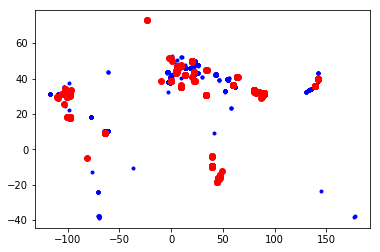

In [9]:
plt.plot(df.lng,df.lat,'b.')
plt.plot(subset.lng,subset.lat,'ro')
plt.show()
